Good Reads:

*   Universal Approximation Theorem: http://neuralnetworksanddeeplearning.com/chap4

*   Activation Functions: https://arxiv.org/pdf/1811.03378.pdf

In [1]:
# imports and inits
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import pytorch_lightning as pl

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers import tensorboard

In [2]:
# model class
class YetztCifarBaseClassification(pl.LightningModule):

  def __init__(self, hparams, model, loss, optimizer, transormations=[]):
    super().__init__()

    self.hparams.update(hparams)    
    self.transormations = transormations
    self.model = model
    self.loss = loss
    self.optimizer = optimizer

  def forward(self, x : torch.tensor):
    # Returns a new tensor with the same data as the self tensor but of a different shape
    x = x.view(x.shape[0], -1)
    return self.model(x)

  def general_step(self, batch, batch_idx, mode):
    images, targets = batch

    # forward pass
    outs = self.forward(images)

    # loss calc
    loss = self.loss(outs, targets)

    preds = outs.argmax(axis=1)
    n_correct = (targets == preds).sum()
    return loss, n_correct

  def general_end(self, outputs, mode):
    # average over all batches aggregated during one epoch
    avg_loss = torch.stack([x[mode + '_loss'] for x in outputs]).mean()
    total_correct = torch.stack([x[mode + '_n_correct'] for x in outputs]).sum().cpu().numpy()
    acc = total_correct / len(self.sampler[mode])
    return avg_loss, acc

  def training_step(self, batch, batch_idx):
    loss, n_correct = self.general_step(batch, batch_idx, "train")
    tensorboard_logs = {'loss': loss}
    
    loggables = {"train_loss": loss, "train_acc": n_correct / self.hparams["batch_size"] } 
    self.log_dict(loggables)

    return {'loss': loss, 'train_n_correct':n_correct, 'log': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss, n_correct = self.general_step(batch, batch_idx, "val")
    
    loggables = {"val_loss": loss, "val_acc": n_correct / self.hparams["batch_size"] } 
    self.log_dict(loggables)
    
    return {'val_loss': loss, 'val_n_correct':n_correct}

  def test_step(self, batch, batch_idx):
    loss, n_correct = self.general_step(batch, batch_idx, "test")
    return {'test_loss': loss, 'test_n_correct':n_correct}

  def validation_end(self, outputs):
    avg_loss, acc = self.general_end(outputs, "val")
    #print("Val-Acc={}".format(acc))
    tensorboard_logs = {'val_loss': avg_loss}
    return {'val_loss': avg_loss, 'val_acc': acc, 'log': tensorboard_logs}

  def prepare_data(self):
      CIFAR_ROOT = "./data/cifar10"

      mean = [0.485, 0.456, 0.406]
      std = [0.229, 0.224, 0.225]

      
      train_val_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
      cifar_complete_augmented = torchvision.datasets.CIFAR10(root=CIFAR_ROOT, transform=self.transormations, download=True)
      cifar_complete_train_val = torchvision.datasets.CIFAR10(root=CIFAR_ROOT, transform=train_val_transform)

      N = len(cifar_complete_augmented)        
      num_train, num_val = int(N*0.6), int(N*0.2)
      np.random.seed(0)
      indices = np.random.permutation(N)
      train_idx, val_idx, test_idx = indices[:num_train], indices[num_train:num_train+num_val], indices[num_train+num_val:]
      train_sampler = SubsetRandomSampler(train_idx)
      val_sampler = SubsetRandomSampler(val_idx)
      test_sampler= SubsetRandomSampler(test_idx)
      self.sampler = {"train": train_sampler, "val": val_sampler, "test": test_sampler}


      # assign to use in dataloaders
      self.dataset = {}
      self.dataset["train"], self.dataset["val"], self.dataset["test"] = cifar_complete_augmented, cifar_complete_train_val, cifar_complete_train_val

  def train_dataloader(self):
      return DataLoader(self.dataset["train"], batch_size=self.hparams["batch_size"], sampler=self.sampler["train"])

  def val_dataloader(self):
      return DataLoader(self.dataset["val"], batch_size=self.hparams["batch_size"], sampler=self.sampler["val"])
  
  def test_dataloader(self):
      return DataLoader(self.dataset["test"], batch_size=self.hparams["batch_size"], sampler=self.sampler["test"])

  def configure_optimizers(self):
      return self.optimizer

  def getTestAcc(self, loader = None):
      self.model.eval()
      self.model = self.model.to(self.device)

      if not loader: loader = self.test_dataloader()

      scores = []
      labels = []

      for batch in loader:
          X, y = batch
          X = X.to(self.device)
          score = self.forward(X)
          scores.append(score.detach().cpu().numpy())
          labels.append(y.detach().cpu().numpy())

      scores = np.concatenate(scores, axis=0)
      labels = np.concatenate(labels, axis=0)

      preds = scores.argmax(axis=1)
      acc = (labels == preds).mean()
      return preds, acc

In [3]:
# device settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# tensorboard settings
%load_ext tensorboard
%tensorboard --logdir drive/MyDrive/lightning_logs --port 6008

In [6]:
# global variables and configs
input_size = 3 * 32 * 32
epochs = 25
batch_size = 64

In [7]:
# Attempt #1 : Bare base model and optimization
# required params: model, loss, optimizer, transormations
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.Sigmoid(),
    nn.Linear(500, 100),
    nn.Sigmoid(),
    nn.Linear(100, 10)
)

# why not a mse error ?
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

hparams = { "batch_size": batch_size }

plModel = YetztCifarBaseClassification(hparams, model, loss, optimizer, transformations)

# prepare data
plModel.prepare_data()

wandb_logger = WandbLogger(project='cifar-10-affine', log_model="all", name="base_reference")

# preapre trainer 
trainer = pl.Trainer(
    max_epochs=epochs,
    gpus=(1 if torch.cuda.is_available() else None),
    logger=wandb_logger
)

wandb_logger.watch(model, log_graph=True)
trainer.fit(plModel)
wandb_logger.experiment.finish()

Files already downloaded and verified


wandb: Currently logged in as: saiftyfirst. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | Sequential       | 1.6 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.350     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▂▂▁▃▂▂▂▄▄▃▃▅▆▁▂▆▅▄▄▄▁▅▅▄▃▅▅▅▅▅▅▄▄██▄█▃▄▇
train_loss,█▆▅▄▅▃▄▄▄▃▄▃▃▃▄▃▃▃▃▃▄▃▃▃▃▃▃▃▂▃▂▂▂▂▁▃▂▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▂▂▂▃▄▄▅▆▇▇▇▇▇▇██████████
val_loss,█▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
epoch,24
train_acc,0.32812
train_loss,2.26544
trainer/global_step,11724
val_acc,0.2429


---------
Initial model takeaways and thoughts
------
1. What is the purpose of the activation function?
- Activation functions allow us to add non-linearities which enable the aproximation of non-linear functions. The universal approximation theorem provides an overview on how a pair of activation functions, approximated as step functions, can represent an arbitrary "rectanagular" bump. Increasing the number of available bumps increases accuracy of the approximation.
- Intuition of on how ReLU fits the universal approximation theorem.



2.   Justify the cost function.
- Cost functions provide a metrix to measure the performance of a neural network in the current configuration. At the end of a forward run of a certain batch of NN training, we can evaluate the loss and conduct gradient descent starting at the loss function in order to propagate gradients back through the network, updating the network parameters along the way.
- Mean squared error (MSE): Average of the square of erros. A good choice for regression problems.
- RMSE: Square root of MSE. In the same unit as the output response.
- Maximum Likelihood Estimation (MLE): In MLE, we assume a  specific parametrized distribution for the data and try to maximize the likelihood that the observed data is from a distrubution by tuning paramaters of the model using backprop.
- Cross Entropy Loss: 
  -  Entropy is a measure of the uncertainty of a random variable. 
  - The intuition for this definition comes if we consider a target or underlying probability distribution P and an approximation of the target distribution Q, then the cross-entropy of Q from P is the number of additional bits to represent an event using Q instead of P.
  - Special case of MLE
  - https://medium.com/konvergen/cross-entropy-and-maximum-likelihood-estimation-58942b52517a
  - https://medium.com/unpackai/cross-entropy-loss-in-ml-d9f22fc11fe0#:~:text=Cross%2Dentropy%20can%20be%20calculated,*%20log(Q(x))
  - Good for classification
  - Pytorch CEntropy: Softmax + CrossEntropy https://discuss.pytorch.org/t/softmax-cross-entropy-loss/125383/6
- Kullback-Leibler divergenc: The terms Kullback-Leibler divergence ( KL divergence for short ) and Kullback-Leibler distance (also Kullback-Leibler entropy or Kullback-Leibler information , after Solomon Kullback and Richard Leibler ; English information gain ) denote a measure of the difference two probability distributions . Typically, one of the distributions represents empirical observations or a precise probability distribution, while the other represents a model or an approximation.

The KL divergence is also called relative entropy , whereby the term relative entropy is occasionally also used for transinformation .  

3. Optimizer.
- We optimize using GD. The issue with NNs is that by adding the activation funtions, we add non-convexity to the problem and hence we have the dangers of getting stuck at local extremum.

Softmax with CrossEntropy or other log-based loss functions

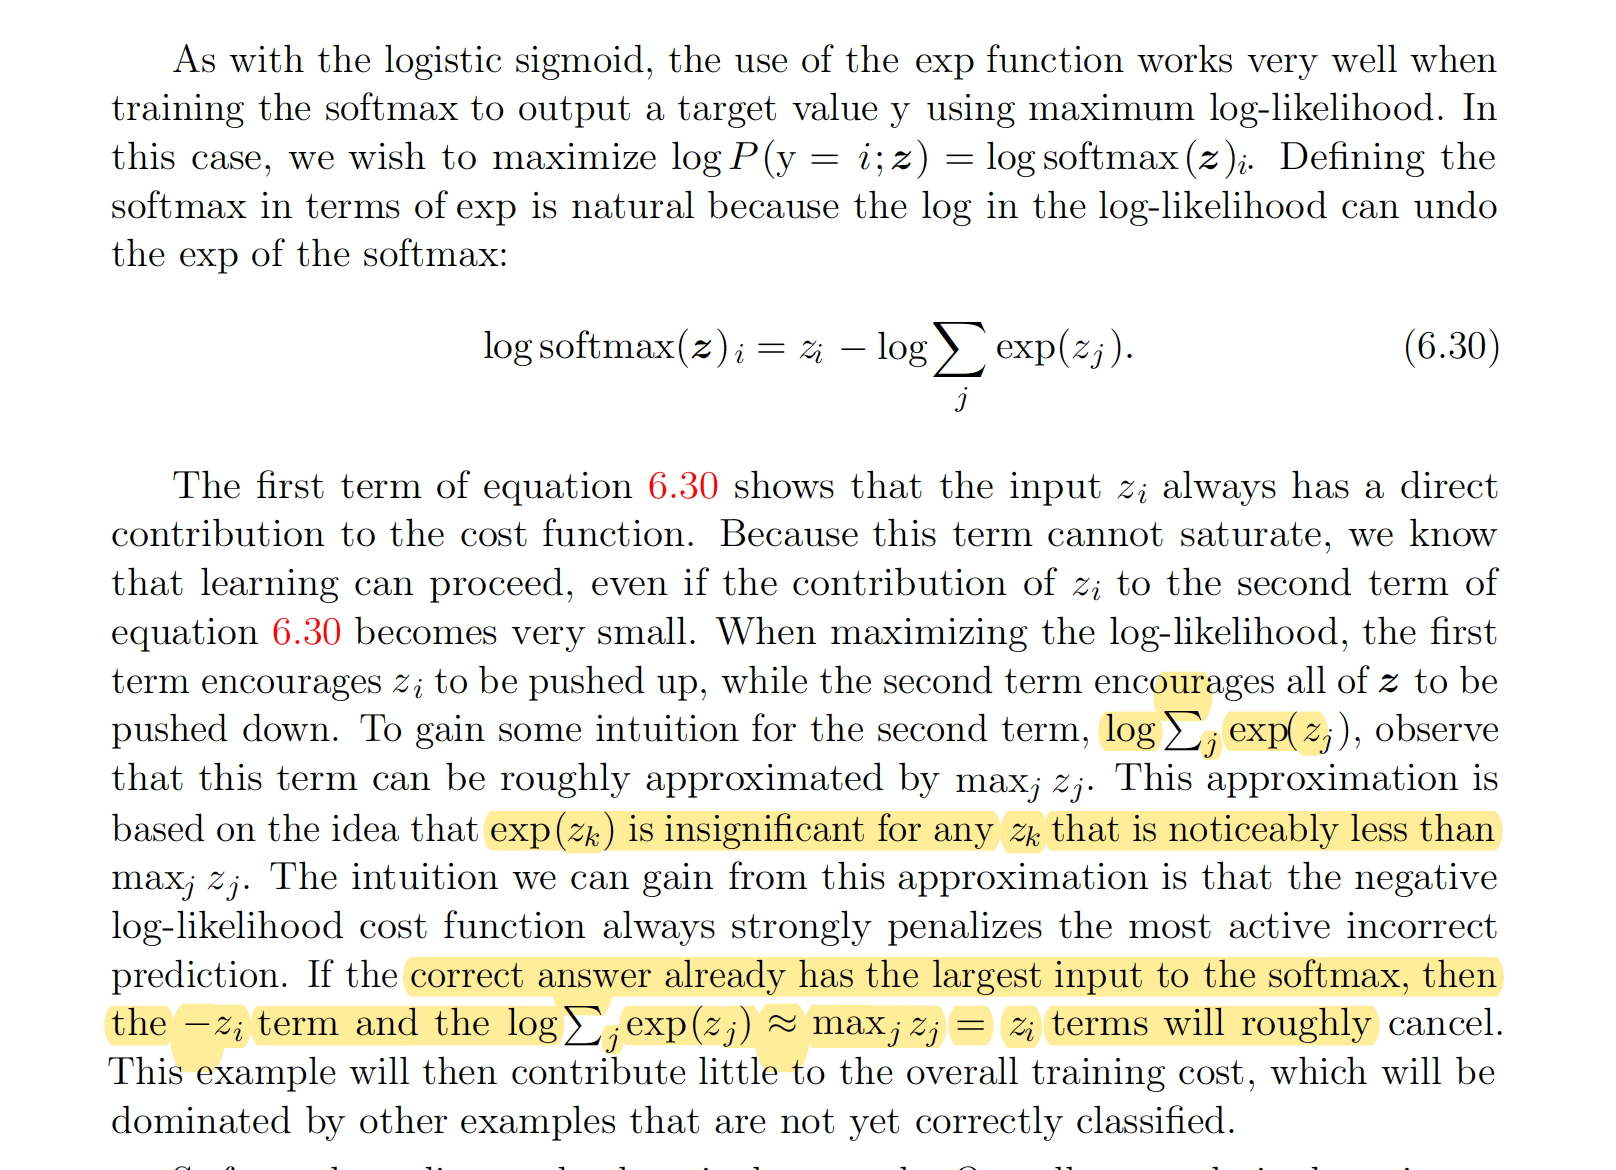

In [8]:
# Attempt #2 : Tanh activation
# required params: model, loss, optimizer, transormations=[]
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.Tanh(),
    nn.Linear(500, 100),
    nn.Tanh(),
    nn.Linear(100, 10)
)

# why not a mse error ?
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

hparams = { "batch_size": batch_size }

plModel = YetztCifarBaseClassification(hparams, model, loss, optimizer, transformations)

# prepare data
plModel.prepare_data()

wandb_logger = WandbLogger(project='cifar-10-affine', log_model="all", name="tanh_activation")

# preapre trainer 
trainer = pl.Trainer(
    max_epochs=epochs,
    gpus=(1 if torch.cuda.is_available() else None),
    logger=wandb_logger
)

wandb_logger.watch(model, log_graph=True)
trainer.fit(plModel)
wandb_logger.experiment.finish()

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | Sequential       | 1.6 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.350     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▅▂▄▅▅▄▄▄▆▄▄▅▄▃▄▄▅▅▄▇▄▇▆▄▅▅▅▆▅▇▆▄▅▅█▄▇▆▅
train_loss,█▇▇▆▅▅▆▇▆▃▆▄▄▅▅▅▄▄▄▅▃▄▃▃▃▂▄▃▂▄▃▃▃▃▄▁▄▁▃▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇████████
val_loss,█▇▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
epoch,24
train_acc,0.32812
train_loss,1.94945
trainer/global_step,11724
val_acc,0.36215


---------
TanH Experiment
------

- Tanh is seen to be learning much faster than the sigmoid activation
- The gradient of tanh is four times greater than the gradient of the sigmoid function. This means that using the tanh activation function results in higher values of gradient during training and higher updates in the weights of the network. So, if we want strong gradients and big learning steps, we should use the tanh activation function.
- Many a times (almost everytime) it happens that the neuron receives data that is not zero-centered. When we use sigmoids and in the case where the data coming into the neuron is always positive, the gradient on the weights ‘w’ will always be either positive or all negative during backpropagation(depending upon the gradient) . Due to this the gradient updates will be very random (zig-zag shape to be precise) which is very undesirable.

In [9]:
# Attempt #3 : Bare base model and optimization
# required params: model, loss, optimizer, transormations=[]

model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.ReLU(),
    nn.Linear(500, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

# why not a mse error ?
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

hparams = { "batch_size": batch_size }

plModel = YetztCifarBaseClassification(hparams, model, loss, optimizer, transformations)

# prepare data
plModel.prepare_data()

wandb_logger = WandbLogger(project='cifar-10-affine', log_model="all", name="relu_activation")

# preapre trainer 
trainer = pl.Trainer(
    max_epochs=epochs,
    gpus=(1 if torch.cuda.is_available() else None),
    logger=wandb_logger
)

wandb_logger.watch(model, log_graph=True)
trainer.fit(plModel)
wandb_logger.experiment.finish()

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | Sequential       | 1.6 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.350     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▁▂▁▅▅▄▅▄▃▅▆▆▄▇▆▅▅▆▅▅▆▆▇▇▅▅▇▇▇▅▅▆▅▅█▅▆▇▇
train_loss,███▇▇▇▆▆▆▆▄▅▅▆▄▅▅▄▅▅▃▃▃▂▃▄▄▂▃▃▃▅▃▆▃▁▅▃▂▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▂▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▇▇▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
epoch,24
train_acc,0.35938
train_loss,1.89155
trainer/global_step,11724
val_acc,0.3547


---------
ReLU Experiment
---------
- Represenmtational Sparsity: 
  - An important benefit of the rectifier function is that it is capable of outputting a true zero value.

  - This is unlike the tanh and sigmoid activation functions that learn to approximate a zero output, e.g. a value very close to zero, but not a true zero value.

 - This means that negative inputs can output true zero values allowing the activation of hidden layers in neural networks to contain one or more true zero values. This is called a sparse representation and is a desirable property in representational learning as it can accelerate learning and simplify the model.

 - An area where efficient representations such as sparsity are studied and sought is in autoencoders, where a network learns a compact representation of an input (called the code layer), such as an image or series, before it is reconstructed from the compact representation.

- Vanishing gradients only for values less than 0. sigmoid and tanh can cause vanishing gradients for both small and large values

- ReLU is not zero-centered so might results in the zig-zag learning pattern 

Here, we observe faster learning than the sigmoid, but comparable learning rate to the tanH. The gradients in the ReLU case have higher maginitudes so lead to faster learning. Since all the inputs to the layers are positive (positive pixel values), we can expect that the zig-zag learning in the ReLU to slow down the learning process.

In [10]:
# Attempt #4 : PReLU activation
# required params: model, loss, optimizer, transormations=[]
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.PReLU(),
    nn.Linear(500, 100),
    nn.PReLU(),
    nn.Linear(100, 10)
)

# why not a mse error ?
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

hparams = { "batch_size": batch_size }

plModel = YetztCifarBaseClassification(hparams, model, loss, optimizer, transformations)

# prepare data
plModel.prepare_data()

wandb_logger = WandbLogger(project='cifar-10-affine', log_model="all", name="prelu_activation")

# preapre trainer 
trainer = pl.Trainer(
    max_epochs=epochs,
    gpus=(1 if torch.cuda.is_available() else None),
    logger=wandb_logger
)

wandb_logger.watch(model, log_graph=True)
trainer.fit(plModel)
wandb_logger.experiment.finish()

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | Sequential       | 1.6 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.350     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▂▁▁▅▄▄▃▇▅▅▅▄▄▄▄▅▃▆▅▆▅▇▇▃▆▅▄▅▆▅▆▆▇▆▅▇██▆
train_loss,███▇▇▆▆▇▅▆▅▅▆▆▅▅▅▆▃▅▃▄▂▃▅▄▄▅▄▃▄▃▂▄▃▂▂▂▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▂▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇█████
val_loss,█▇▇▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch,24
train_acc,0.39062
train_loss,1.76619
trainer/global_step,11724
val_acc,0.3611


In [11]:
# Attempt #5 : elu activation
# required params: model, loss, optimizer, transormations=[]
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.ELU(),
    nn.Linear(500, 100),
    nn.ELU(),
    nn.Linear(100, 10)
)

# why not a mse error ?
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

hparams = { "batch_size": batch_size }

plModel = YetztCifarBaseClassification(hparams, model, loss, optimizer, transformations)

# prepare data
plModel.prepare_data()

wandb_logger = WandbLogger(project='cifar-10-affine', log_model="all", name="elu_activation")

# preapre trainer 
trainer = pl.Trainer(
    max_epochs=epochs,
    gpus=(1 if torch.cuda.is_available() else None),
    logger=wandb_logger
)

wandb_logger.watch(model, log_graph=True)
trainer.fit(plModel)
wandb_logger.experiment.finish()

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | Sequential       | 1.6 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.350     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,▁▃▄▃▄▄▆▆▅▄▅▆▅▄▅▄▆▅▄▇▆█▄▅▇▆▆▄▇▆▇▇▇▅▄▇▅▆▇▇
train_loss,██▆▇▆▆▅▅▄▆▅▄▄▅▅▅▃▄▆▂▄▁▅▄▃▃▂▅▂▂▂▃▂▄▄▁▅▃▂▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████
val_loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch,24
train_acc,0.4375
train_loss,1.81449
trainer/global_step,11724
val_acc,0.3806


In [12]:
# Attempt #6 : Hardswish activation
# required params: model, loss, optimizer, transormations=[]

model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.Hardswish(),
    nn.Linear(500, 100),
    nn.Hardswish(),
    nn.Linear(100, 10)
)

# why not a mse error ?
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

hparams = { "batch_size": batch_size }

plModel = YetztCifarBaseClassification(hparams, model, loss, optimizer, transformations)

# prepare data
plModel.prepare_data()

wandb_logger = WandbLogger(project='cifar-10-affine', log_model="all", name="hswish_activation")

# preapre trainer 
trainer = pl.Trainer(
    max_epochs=epochs,
    gpus=(1 if torch.cuda.is_available() else None),
    logger=wandb_logger
)

wandb_logger.watch(model, log_graph=True)
trainer.fit(plModel)
wandb_logger.experiment.finish()

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | Sequential       | 1.6 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.350     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


In [ ]:
# Attempt #7 : LeakuReLU activation
# required params: model, loss, optimizer, transormations=[]

model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 100),
    nn.Hardswish(),
    nn.LeakyReLU(100, 10)
)

# why not a mse error ?
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

hparams = { "batch_size": batch_size }

plModel = YetztCifarBaseClassification(hparams, model, loss, optimizer, transformations)

# prepare data
plModel.prepare_data()

wandb_logger = WandbLogger(project='cifar-10-affine', log_model="all", name="lrelu_activation")

# preapre trainer 
trainer = pl.Trainer(
    max_epochs=epochs,
    gpus=(1 if torch.cuda.is_available() else None),
    logger=wandb_logger
)

wandb_logger.watch(model, log_graph=True)
trainer.fit(plModel)
wandb_logger.experiment.finish()

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | Sequential       | 1.6 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.346     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
'''
  Next Steps:
    - Overfit
      - Increase the number of hidden units?
      - Increase the number of layers?
    Regularize
      - Investigate L1 vs L2 regularization
      - Dropouts
      - Augmentation
    Investigate optimization methods
'''

'\n  Next Steps:\n    - Overfit\n      - Increase the number of hidden units?\n      - Increase the number of layers?\n    Regularize\n      - Investigate L1 vs L2 regularization\n      - Dropouts\n      - Augmentation\n    Investigate optimization methods\n'